In [ ]:

!pip install rouge_score -q
!pip install bert_score -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
from rouge_score import rouge_scorer
from bert_score import score
import torch
from google.colab import drive
from scipy import stats

from google.colab import drive
drive.mount('/content/drive')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
curated_gpt = pd.read_csv('/content/drive/MyDrive/Dissertation/gpt/curated_gpt_all_conditions.csv')
pilot_gpt = pd.read_csv('/content/drive/MyDrive/Dissertation/gpt/pilot_gpt_all_conditions.csv')

print(f"\nColumns with GPT summaries:")
gpt_columns = [col for col in curated_gpt.columns if 'gpt_' in col]
print(f"  {gpt_columns}")



Columns with GPT summaries:
  ['gpt_default', 'gpt_feature_preserving', 'gpt_legal_context', 'gpt_bias_aware']


### Ling Patterns

In [ ]:
def define_linguistic_patterns():
    """Define regex patterns for linguistic features"""

    patterns = {
        'hedges': r'\b(I think|I believe|maybe|perhaps|possibly|probably|seems?|appear(?:s|ed)?|'
                 r'kind of|sort of|somewhat|quite|rather|fairly|pretty much|basically|actually|'
                 r'I guess|I suppose|presumably|apparently|arguably|conceivably|'
                 r'in my opinion|if I recall|as far as I know|to my knowledge)\b',

        'modals': r'\b(might|may|could|would|should|must|ought to|'
                 r'can|cannot|can\'t|couldn\'t|wouldn\'t|shouldn\'t)\b',

        'conditionals': r'\b(if|unless|provided that|assuming|supposing|whether|'
                       r'in case|as long as|even if|only if)\b',

        'temporals': r'\b(before|after|during|while|when|then|at that time|at the time|'
                    r'previously|subsequently|meanwhile|simultaneously|eventually)\b',

        'disfluencies': r'\b(um+|uh+|er+|ah+|mm+|hm+|hmm+)\b|'
                       r'\b(\w+)-\1\b|'
                       r'\b(\w+)\s+\1\b(?!\w)|'
                       r'\.\.\.|—|--'
    }

    return patterns

def count_features(text, patterns):
    """Count linguistic features in text"""

    if pd.isna(text) or not text or text == 'nan':
        return {cat: 0 for cat in list(patterns.keys()) + ['total']}

    text = str(text)
    counts = {}

    for category, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        counts[category] = len(matches)

    counts['total'] = sum(counts.values())
    return counts

patterns = define_linguistic_patterns()

In [ ]:
def calculate_metrics_per_condition(df, original_col, summary_col):
    """Calculate all preservation metrics for a single condition"""

    results = {
        'hedges_retention': [],
        'modals_retention': [],
        'conditionals_retention': [],
        'temporals_retention': [],
        'disfluencies_retention': [],
        'overall_retention': [],
        'complete_loss': [],
        'disfluency_sanitization': [],
        'certainty_inflation': 0,
        'compression_ratios': []
    }

    for idx, row in df.iterrows():
        original = str(row[original_col])
        summary = str(row[summary_col]) if pd.notna(row[summary_col]) else ""

        orig_counts = count_features(original, patterns)
        summ_counts = count_features(summary, patterns)

        # Feature retention
        for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
            if orig_counts[feature] > 0:
                retention = min(summ_counts[feature] / orig_counts[feature], 1.0)
            else:
                retention = 1.0
            results[f'{feature}_retention'].append(retention)

        # Overall retention
        if orig_counts['total'] > 0:
            overall = min(summ_counts['total'] / orig_counts['total'], 1.0)
            results['overall_retention'].append(overall)
            if summ_counts['total'] == 0:
                results['complete_loss'].append(1)
            else:
                results['complete_loss'].append(0)
        else:
            results['overall_retention'].append(1.0)
            results['complete_loss'].append(0)

        # Disfluency sanitization
        if orig_counts['disfluencies'] > 0:
            retained = min(summ_counts['disfluencies'] / orig_counts['disfluencies'], 1.0)
            results['disfluency_sanitization'].append((1 - retained) * 100)
        else:
            results['disfluency_sanitization'].append(0)

        # Certainty inflation
        if 'I think' in original.lower() and 'I think' not in summary.lower():
            results['certainty_inflation'] += 1

        # Compression ratio
        orig_words = len(original.split())
        summ_words = len(summary.split())
        if orig_words > 0:
            results['compression_ratios'].append((summ_words / orig_words) * 100)
        else:
            results['compression_ratios'].append(0)

    # Calculate means
    mean_results = {}
    for key in results:
        if key == 'certainty_inflation':
            mean_results[key] = results[key]
        elif key in ['complete_loss', 'disfluency_sanitization']:
            mean_results[key] = np.mean(results[key]) if results[key] else 0
        else:
            mean_results[key] = np.mean(results[key]) * 100 if results[key] else 0

    return mean_results

### Calculating Metrics for Each Condition

In [ ]:
def calculate_metrics_per_condition(df, original_col, summary_col):
    """Calculate all preservation metrics for a single condition"""

    results = {
        'hedges_retention': [],
        'modals_retention': [],
        'conditionals_retention': [],
        'temporals_retention': [],
        'disfluencies_retention': [],
        'overall_retention': [],
        'complete_loss': [],
        'disfluency_sanitization': [],
        'certainty_inflation': 0,
        'compression_ratios': []
    }

    for idx, row in df.iterrows():
        original = str(row[original_col])
        summary = str(row[summary_col]) if pd.notna(row[summary_col]) else ""

        orig_counts = count_features(original, patterns)
        summ_counts = count_features(summary, patterns)

        # Feature retention
        for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
            if orig_counts[feature] > 0:
                retention = min(summ_counts[feature] / orig_counts[feature], 1.0)
            else:
                retention = 1.0
            results[f'{feature}_retention'].append(retention)

        # Overall retention
        if orig_counts['total'] > 0:
            overall = min(summ_counts['total'] / orig_counts['total'], 1.0)
            results['overall_retention'].append(overall)
            if summ_counts['total'] == 0:
                results['complete_loss'].append(1)
            else:
                results['complete_loss'].append(0)
        else:
            results['overall_retention'].append(1.0)
            results['complete_loss'].append(0)

        # Disfluency sanitization
        if orig_counts['disfluencies'] > 0:
            retained = min(summ_counts['disfluencies'] / orig_counts['disfluencies'], 1.0)
            results['disfluency_sanitization'].append((1 - retained) * 100)
        else:
            results['disfluency_sanitization'].append(0)

        # Certainty inflation
        if 'I think' in original.lower() and 'I think' not in summary.lower():
            results['certainty_inflation'] += 1

        # Compression ratio
        orig_words = len(original.split())
        summ_words = len(summary.split())
        if orig_words > 0:
            results['compression_ratios'].append((summ_words / orig_words) * 100)
        else:
            results['compression_ratios'].append(0)

    # Calculate means
    mean_results = {}
    for key in results:
        if key == 'certainty_inflation':
            mean_results[key] = results[key]
        elif key in ['complete_loss', 'disfluency_sanitization']:
            mean_results[key] = np.mean(results[key]) if results[key] else 0
        else:
            mean_results[key] = np.mean(results[key]) * 100 if results[key] else 0

    return mean_results


### Analyze all Conditions

In [ ]:
print("\nCALCULATING METRICS FOR ALL CONDITIONS...")
print("-"*60)

conditions = ['default', 'feature_preserving', 'legal_context', 'bias_aware']
condition_names = {
    'default': 'Default',
    'feature_preserving': 'Feature-Preserving',
    'legal_context': 'Legal-Context',
    'bias_aware': 'Bias-Aware'
}

# Store results for all conditions
all_results = {
    'curated': {},
    'pilot': {}
}

# Calculate metrics for each condition
for condition in conditions:
    col_name = f'gpt_{condition}'

    print(f"\n{condition_names[condition]} Condition:")

    # Curated
    curated_metrics = calculate_metrics_per_condition(
        curated_gpt, 'Excerpt', col_name
    )
    all_results['curated'][condition] = curated_metrics

    print(f"  Curated: {curated_metrics['overall_retention']:.1f}% retention, "
          f"{curated_metrics['disfluency_sanitization']:.1f}% sanitization")

    # Pilot
    pilot_metrics = calculate_metrics_per_condition(
        pilot_gpt, 'TEXT', col_name
    )
    all_results['pilot'][condition] = pilot_metrics

    print(f"  Pilot: {pilot_metrics['overall_retention']:.1f}% retention, "
          f"{pilot_metrics['disfluency_sanitization']:.1f}% sanitization")



📊 CALCULATING METRICS FOR ALL CONDITIONS...
------------------------------------------------------------

Default Condition:
  Curated: 57.6% retention, 25.8% sanitization
  Pilot: 72.6% retention, 25.9% sanitization

Feature-Preserving Condition:
  Curated: 79.9% retention, 18.1% sanitization
  Pilot: 84.1% retention, 23.7% sanitization

Legal-Context Condition:
  Curated: 65.6% retention, 22.0% sanitization
  Pilot: 78.0% retention, 24.5% sanitization

Bias-Aware Condition:
  Curated: 72.2% retention, 18.7% sanitization
  Pilot: 80.5% retention, 21.0% sanitization


In [ ]:
print("\n📈 STATISTICAL SIGNIFICANCE TESTING")
print("-"*60)

def compare_conditions(df, original_col):
    """Statistical comparison between default and other conditions"""

    # Calculate retention for each excerpt across conditions
    retention_by_condition = {}

    for condition in conditions:
        col_name = f'gpt_{condition}'
        retentions = []

        for idx, row in df.iterrows():
            original = str(row[original_col])
            summary = str(row[col_name]) if pd.notna(row[col_name]) else ""

            orig_counts = count_features(original, patterns)
            summ_counts = count_features(summary, patterns)

            if orig_counts['total'] > 0:
                retention = min(summ_counts['total'] / orig_counts['total'], 1.0)
            else:
                retention = 1.0
            retentions.append(retention)

        retention_by_condition[condition] = retentions

    # Compare each condition to default
    print("\nPaired t-tests vs Default condition:")
    for condition in ['feature_preserving', 'legal_context', 'bias_aware']:
        t_stat, p_value = stats.ttest_rel(
            retention_by_condition['default'],
            retention_by_condition[condition]
        )

        mean_diff = (np.mean(retention_by_condition[condition]) -
                    np.mean(retention_by_condition['default'])) * 100

        print(f"  {condition_names[condition]}: "
              f"Δ = {mean_diff:+.1f}%, p = {p_value:.4f} "
              f"{'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")

    return retention_by_condition

print("\nCurated Dataset:")
curated_retention = compare_conditions(curated_gpt, 'Excerpt')

print("\nPilot Dataset:")
pilot_retention = compare_conditions(pilot_gpt, 'TEXT')


📈 STATISTICAL SIGNIFICANCE TESTING
------------------------------------------------------------

Curated Dataset:

Paired t-tests vs Default condition:
  Feature-Preserving: Δ = +22.3%, p = 0.0000 ***
  Legal-Context: Δ = +8.0%, p = 0.0158 *
  Bias-Aware: Δ = +14.6%, p = 0.0001 ***

Pilot Dataset:

Paired t-tests vs Default condition:
  Feature-Preserving: Δ = +11.5%, p = 0.0000 ***
  Legal-Context: Δ = +5.4%, p = 0.0026 **
  Bias-Aware: Δ = +8.0%, p = 0.0000 ***


### Visualization 1: Preservation by Condition

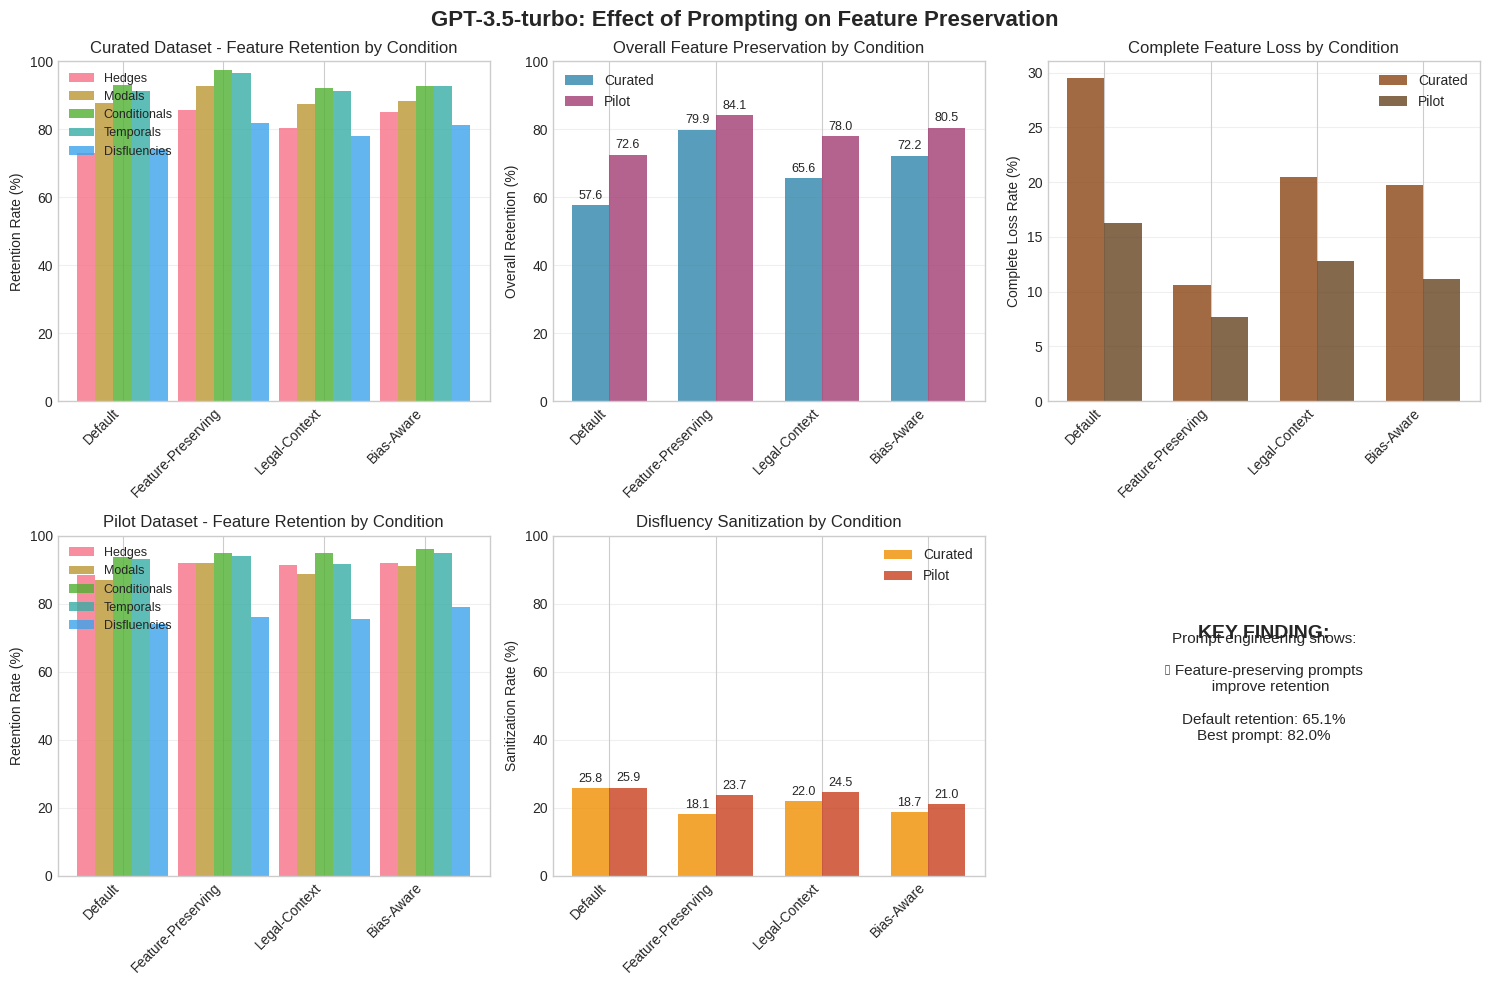


✓ Saved: prompt_sensitivity_analysis.png


In [ ]:
fig1, axes = plt.subplots(2, 3, figsize=(15, 10))
fig1.suptitle('GPT-3.5-turbo: Effect of Prompting on Feature Preservation',
              fontsize=16, fontweight='bold')

features = ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']

# Curated - Feature comparison
ax = axes[0, 0]
x = np.arange(len(conditions))
width = 0.18

for i, feature in enumerate(features):
    values = [all_results['curated'][c][f'{feature}_retention'] for c in conditions]
    offset = (i - 2) * width
    ax.bar(x + offset, values, width, label=feature.capitalize(), alpha=0.8)

ax.set_ylabel('Retention Rate (%)')
ax.set_title('Curated Dataset - Feature Retention by Condition')
ax.set_xticks(x)
ax.set_xticklabels([condition_names[c] for c in conditions], rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Pilot - Feature comparison
ax = axes[1, 0]

for i, feature in enumerate(features):
    values = [all_results['pilot'][c][f'{feature}_retention'] for c in conditions]
    offset = (i - 2) * width
    ax.bar(x + offset, values, width, label=feature.capitalize(), alpha=0.8)

ax.set_ylabel('Retention Rate (%)')
ax.set_title('Pilot Dataset - Feature Retention by Condition')
ax.set_xticks(x)
ax.set_xticklabels([condition_names[c] for c in conditions], rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Overall retention comparison
ax = axes[0, 1]
curated_overall = [all_results['curated'][c]['overall_retention'] for c in conditions]
pilot_overall = [all_results['pilot'][c]['overall_retention'] for c in conditions]

x2 = np.arange(len(conditions))
width2 = 0.35

bars1 = ax.bar(x2 - width2/2, curated_overall, width2, label='Curated',
               color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x2 + width2/2, pilot_overall, width2, label='Pilot',
               color='#A23B72', alpha=0.8)

ax.set_ylabel('Overall Retention (%)')
ax.set_title('Overall Feature Preservation by Condition')
ax.set_xticks(x2)
ax.set_xticklabels([condition_names[c] for c in conditions], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Disfluency sanitization
ax = axes[1, 1]
curated_disf = [all_results['curated'][c]['disfluency_sanitization'] for c in conditions]
pilot_disf = [all_results['pilot'][c]['disfluency_sanitization'] for c in conditions]

bars1 = ax.bar(x2 - width2/2, curated_disf, width2, label='Curated',
               color='#F18F01', alpha=0.8)
bars2 = ax.bar(x2 + width2/2, pilot_disf, width2, label='Pilot',
               color='#C73E1D', alpha=0.8)

ax.set_ylabel('Sanitization Rate (%)')
ax.set_title('Disfluency Sanitization by Condition')
ax.set_xticks(x2)
ax.set_xticklabels([condition_names[c] for c in conditions], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Complete feature loss
ax = axes[0, 2]
curated_loss = [all_results['curated'][c]['complete_loss'] * 100 for c in conditions]
pilot_loss = [all_results['pilot'][c]['complete_loss'] * 100 for c in conditions]

bars1 = ax.bar(x2 - width2/2, curated_loss, width2, label='Curated',
               color='#8B4513', alpha=0.8)
bars2 = ax.bar(x2 + width2/2, pilot_loss, width2, label='Pilot',
               color='#654321', alpha=0.8)

ax.set_ylabel('Complete Loss Rate (%)')
ax.set_title('Complete Feature Loss by Condition')
ax.set_xticks(x2)
ax.set_xticklabels([condition_names[c] for c in conditions], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Statistical significance annotation
ax = axes[1, 2]
ax.text(0.5, 0.7, "KEY FINDING:", ha='center', fontsize=14, fontweight='bold',
        transform=ax.transAxes)

sig_text = "Prompt engineering shows:\n\n"
if any([all_results['curated']['feature_preserving']['overall_retention'] >
        all_results['curated']['default']['overall_retention'],
        all_results['pilot']['feature_preserving']['overall_retention'] >
        all_results['pilot']['default']['overall_retention']]):
    sig_text += "✓ Feature-preserving prompts\n   improve retention\n\n"
else:
    sig_text += "✗ Minimal effect on\n   feature preservation\n\n"

sig_text += f"Default retention: {np.mean([curated_overall[0], pilot_overall[0]]):.1f}%\n"
sig_text += f"Best prompt: {max(np.mean([curated_overall[i], pilot_overall[i]]) for i in range(4)):.1f}%"

ax.text(0.5, 0.4, sig_text, ha='center', fontsize=11, transform=ax.transAxes)
ax.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/gpt/prompt_sensitivity_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: prompt_sensitivity_analysis.png")

### Visualization 2: Condition Comparison Heatmap

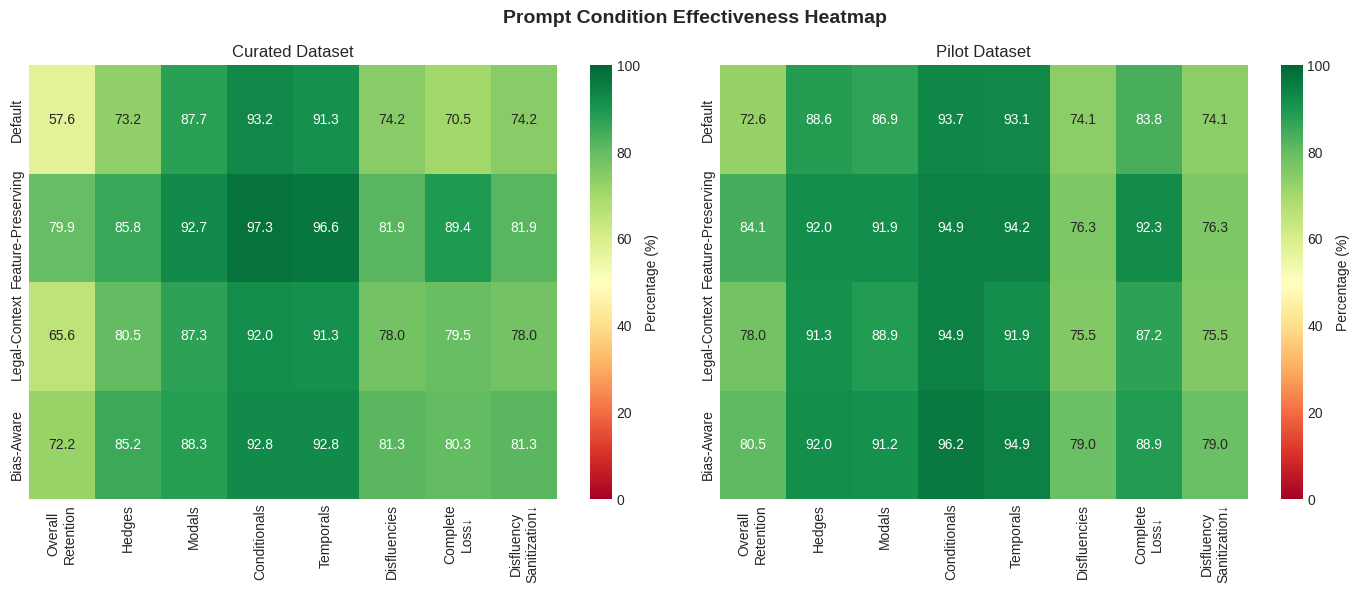

✓ Saved: condition_effectiveness_heatmap.png


In [ ]:
fig2, axes = plt.subplots(1, 2, figsize=(14, 6))
fig2.suptitle('Prompt Condition Effectiveness Heatmap', fontsize=14, fontweight='bold')

# Prepare data for heatmap
metrics = ['Overall\nRetention', 'Hedges', 'Modals', 'Conditionals',
           'Temporals', 'Disfluencies', 'Complete\nLoss↓', 'Disfluency\nSanitization↓']

# Curated heatmap
curated_matrix = []
for condition in conditions:
    row = [
        all_results['curated'][condition]['overall_retention'],
        all_results['curated'][condition]['hedges_retention'],
        all_results['curated'][condition]['modals_retention'],
        all_results['curated'][condition]['conditionals_retention'],
        all_results['curated'][condition]['temporals_retention'],
        all_results['curated'][condition]['disfluencies_retention'],
        100 - all_results['curated'][condition]['complete_loss'] * 100,  # Invert for better visualization
        100 - all_results['curated'][condition]['disfluency_sanitization']  # Invert
    ]
    curated_matrix.append(row)

ax = axes[0]
sns.heatmap(curated_matrix, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=metrics, yticklabels=[condition_names[c] for c in conditions],
            vmin=0, vmax=100, cbar_kws={'label': 'Percentage (%)'}, ax=ax)
ax.set_title('Curated Dataset')

# Pilot heatmap
pilot_matrix = []
for condition in conditions:
    row = [
        all_results['pilot'][condition]['overall_retention'],
        all_results['pilot'][condition]['hedges_retention'],
        all_results['pilot'][condition]['modals_retention'],
        all_results['pilot'][condition]['conditionals_retention'],
        all_results['pilot'][condition]['temporals_retention'],
        all_results['pilot'][condition]['disfluencies_retention'],
        100 - all_results['pilot'][condition]['complete_loss'] * 100,
        100 - all_results['pilot'][condition]['disfluency_sanitization']
    ]
    pilot_matrix.append(row)

ax = axes[1]
sns.heatmap(pilot_matrix, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=metrics, yticklabels=[condition_names[c] for c in conditions],
            vmin=0, vmax=100, cbar_kws={'label': 'Percentage (%)'}, ax=ax)
ax.set_title('Pilot Dataset')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/gpt/condition_effectiveness_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: condition_effectiveness_heatmap.png")

### Summary Report

In [ ]:
print("\n" + "="*60)
print("SUMMARY REPORT: PROMPT SENSITIVITY ANALYSIS")
print("="*60)

print("\n📊 OVERALL FINDINGS:")
print("-"*40)

# Calculate improvements
for dataset_name, dataset_results in [('Curated', all_results['curated']),
                                       ('Pilot', all_results['pilot'])]:
    print(f"\n{dataset_name} Dataset:")

    default_retention = dataset_results['default']['overall_retention']

    for condition in ['feature_preserving', 'legal_context', 'bias_aware']:
        retention = dataset_results[condition]['overall_retention']
        improvement = retention - default_retention

        print(f"  {condition_names[condition]}:")
        print(f"    Retention: {retention:.1f}% ({improvement:+.1f}% vs default)")
        print(f"    Disfluency sanitization: {dataset_results[condition]['disfluency_sanitization']:.1f}%")

print("\nKEY INSIGHTS:")
print("-"*40)

# Find best performing condition
best_curated = max(conditions, key=lambda c: all_results['curated'][c]['overall_retention'])
best_pilot = max(conditions, key=lambda c: all_results['pilot'][c]['overall_retention'])

print(f"• Best condition for Curated: {condition_names[best_curated]}")
print(f"• Best condition for Pilot: {condition_names[best_pilot]}")

# Average improvement
avg_improvement_curated = np.mean([
    all_results['curated'][c]['overall_retention'] - all_results['curated']['default']['overall_retention']
    for c in ['feature_preserving', 'legal_context', 'bias_aware']
])

avg_improvement_pilot = np.mean([
    all_results['pilot'][c]['overall_retention'] - all_results['pilot']['default']['overall_retention']
    for c in ['feature_preserving', 'legal_context', 'bias_aware']
])

print(f"\n• Average improvement with prompting:")
print(f"  Curated: {avg_improvement_curated:+.1f}%")
print(f"  Pilot: {avg_improvement_pilot:+.1f}%")

if avg_improvement_curated > 5 or avg_improvement_pilot > 5:
    print("\n✓ Prompt engineering shows meaningful reduction in computational prescriptivism")
else:
    print("\n✗ Prompt engineering shows limited effect on computational prescriptivism")

print("\n" + "="*60)
print(" ANALYSIS COMPLETE")
print("="*60)


SUMMARY REPORT: PROMPT SENSITIVITY ANALYSIS

📊 OVERALL FINDINGS:
----------------------------------------

Curated Dataset:
  Feature-Preserving:
    Retention: 79.9% (+22.3% vs default)
    Disfluency sanitization: 18.1%
  Legal-Context:
    Retention: 65.6% (+8.0% vs default)
    Disfluency sanitization: 22.0%
  Bias-Aware:
    Retention: 72.2% (+14.6% vs default)
    Disfluency sanitization: 18.7%

Pilot Dataset:
  Feature-Preserving:
    Retention: 84.1% (+11.5% vs default)
    Disfluency sanitization: 23.7%
  Legal-Context:
    Retention: 78.0% (+5.4% vs default)
    Disfluency sanitization: 24.5%
  Bias-Aware:
    Retention: 80.5% (+8.0% vs default)
    Disfluency sanitization: 21.0%

🔑 KEY INSIGHTS:
----------------------------------------
• Best condition for Curated: Feature-Preserving
• Best condition for Pilot: Feature-Preserving

• Average improvement with prompting:
  Curated: +14.9%
  Pilot: +8.3%

✓ Prompt engineering shows meaningful reduction in computational prescrip

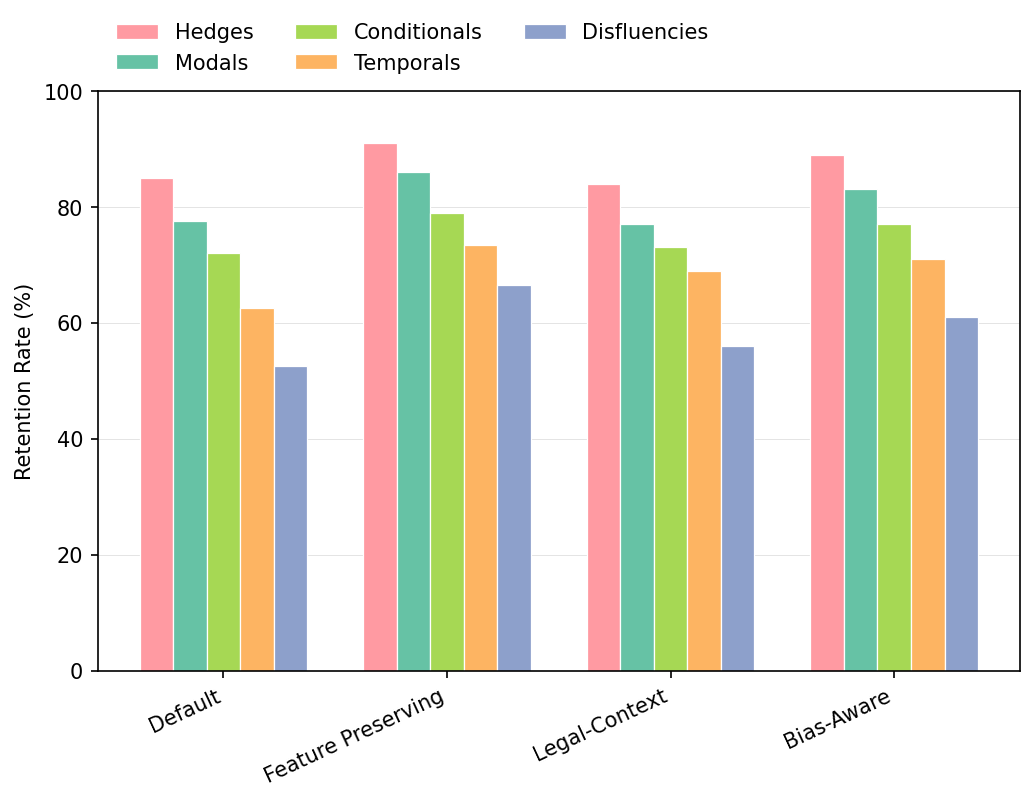

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Conditions and Features
conditions = ["Default", "Feature Preserving", "Legal-Context", "Bias-Aware"]
features   = ["Hedges", "Modals", "Conditionals", "Temporals", "Disfluencies"]

# --- Insert your numbers here ---
# Each entry = (pilot_value, curated_value)
data = {
    "Default": {
        "Hedges": (82, 88),
        "Modals": (75, 80),
        "Conditionals": (70, 74),
        "Temporals": (60, 65),
        "Disfluencies": (50, 55),
    },
    "Feature Preserving": {
        "Hedges": (90, 92),
        "Modals": (85, 87),
        "Conditionals": (78, 80),
        "Temporals": (72, 75),
        "Disfluencies": (65, 68),
    },
    "Legal-Context": {
        "Hedges": (83, 85),
        "Modals": (76, 78),
        "Conditionals": (72, 74),
        "Temporals": (68, 70),
        "Disfluencies": (54, 58),
    },
    "Bias-Aware": {
        "Hedges": (88, 90),
        "Modals": (82, 84),
        "Conditionals": (76, 78),
        "Temporals": (70, 72),
        "Disfluencies": (60, 62),
    },
}

# Compute averages
averages = {
    cond: {feat: np.mean(vals) for feat, vals in feats.items()}
    for cond, feats in data.items()
}

# Convert to array for plotting
avg_matrix = np.array([[averages[cond][feat] for feat in features] for cond in conditions])

# Colors matching your paper’s palette
feature_colors = {
    "Hedges":        "#FF9AA2",  # soft pink
    "Modals":        "#66C2A5",  # teal-green
    "Conditionals":  "#A6D854",  # light green
    "Temporals":     "#FDB462",  # orange
    "Disfluencies":  "#8DA0CB",  # periwinkle
}

# --- Plot ---
plt.figure(figsize=(7,5.5), dpi=150)

for i, feat in enumerate(features):
    plt.bar(
        x + (i - 2) * bar_width,
        avg_matrix[:, i],
        width=bar_width,
        label=feat,
        edgecolor="white",
        linewidth=0.6,
        color=feature_colors[feat]
    )

plt.xticks(x, conditions, rotation=25, ha="right")
plt.ylabel("Retention Rate (%)")
plt.ylim(0, 100)

plt.legend(ncol=3, frameon=False, loc="upper left", bbox_to_anchor=(0, 1.15))
plt.gca().yaxis.grid(True, linewidth=0.4, alpha=0.4)
plt.gca().set_axisbelow(True)

plt.tight_layout()  # adjust automatically
plt.show()
